# Experiments on the design of the agentic system

In [3]:
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv
# from langchain_mistralai import MistralAIEmbeddings
import pandas as pd
import json
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_core.tools import tool
import numpy as np
import sys
from typing import (Annotated,Sequence,TypedDict,Any,Optional,Dict,Union,Literal)
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage,SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import StateGraph, START, END, MessagesState

load_dotenv()
model_id = "openai/gpt-oss-20b" # 	qwen/qwen3-32b  openai/gpt-oss-20b llama-3.1-8b-instant
groq_api_key = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model=model_id,
            temperature=0,
            max_tokens=None,
            timeout=None,
            max_retries=2,
            verbose=1)

# Create embedding model
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")


sys.path.append('../src')

/var/folders/0z/6z_9lrtd6j3_gnlsyv9rb5b00000gn/T/ipykernel_1178/2848597642.py:29: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")


## Import and Parse data

In [2]:
# Load the required data and documents 
from parsing_helpers import fin_doc_parser, parse_embedding

document = '../data/suncorp_financial report 2024.pdf'

df_docs, docs = fin_doc_parser(document, embedding_model, min_chunk_length=800)



2025-10-12 15:26:18,821 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-10-12 15:26:18,883 - INFO - Going to convert document batch...
2025-10-12 15:26:18,884 - INFO - Initializing pipeline for StandardPdfPipeline with options hash e647edf348883bed75367b22fbe60347
2025-10-12 15:26:18,892 - INFO - Loading plugin 'docling_defaults'
2025-10-12 15:26:18,894 - INFO - Registered picture descriptions: ['vlm', 'api']
2025-10-12 15:26:18,904 - INFO - Loading plugin 'docling_defaults'
2025-10-12 15:26:18,907 - INFO - Registered ocr engines: ['easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']
2025-10-12 15:26:19,109 - INFO - Accelerator device: 'mps'
2025-10-12 15:26:21,781 - INFO - Accelerator device: 'mps'
2025-10-12 15:26:23,321 - INFO - Accelerator device: 'mps'
2025-10-12 15:26:23,982 - INFO - Processing document suncorp_financial report 2024.pdf
2025-10-12 15:34:10,268 - INFO - Finished converting document suncorp_financial report 2024.pdf in 471.45 sec.


In [8]:
# Load Suncorp df_docs

df_docs.to_csv('../data/df_docs.csv', index=False)



In [2]:
# Load the  Suncorp df_docs

from parsing_helpers import  parse_embedding

df_docs = pd.read_csv('../data/df_docs.csv')

# Parse the 'summary_emb' column from JSON strings to numpy arrays
df_docs["content_embed"] = df_docs["content_embed"].apply(parse_embedding)

In [4]:
# Load the FinQA dataset

from parsing_helpers import  parse_embedding


df_finqa_0 = pd.read_csv('../data/convfinqa_full.csv')

# Parse the 'summary_emb' column from JSON strings to numpy arrays
df_finqa_0["summary_emb"] = df_finqa_0["summary_emb"].apply(parse_embedding)

df_finqa = df_finqa_0[df_finqa_0['has_type2_question'] == True].reset_index(drop=True)

print(type(df_finqa['summary_emb'].iloc[0]))
df_finqa.head()

<class 'numpy.ndarray'>


,id,doc,dialogue,features,summary,summary_emb,dialogue_dict,conv_questions,conv_answers,turn_program,executed_answers,qa_split,conv_text_full,features_dict,num_dialogue_turns,has_type2_question,has_duplicate_columns,has_non_numeric_values
0,Double_UPS/2009/page_33.pdf,{'pre_text': '( 1 ) includes shares repurchase...,{'conv_questions': ['what was the fluctuation ...,"{'num_dialogue_turns': 7, 'has_type2_question'...",Topic: Shareowner Return Performance Graph for...,"[-0.00287797605, -0.0426896326, -0.00222300575...",{'conv_questions': ['what was the fluctuation ...,['what was the fluctuation of the performance ...,"['-8.94', '-8.9%', '-24.05', '-24.05%', '2.11'...","['subtract(91.06, const_100)', 'subtract(91.06...","[-8.94, -0.0894, -24.05, -0.2405, 2.11, 0.0211...","[False, False, True, True, True, True, True]","""""""\nQ: what was the fluctuation of the perfor...","{'num_dialogue_turns': 7, 'has_type2_question'...",7,True,False,False
1,Double_AES/2016/page_98.pdf,"{'pre_text': ""the net decrease in the 2016 eff...",{'conv_questions': ['what was the total of for...,"{'num_dialogue_turns': 4, 'has_type2_question'...",Topic: \nForeign Currency Transaction Gains an...,"[-0.0433199666, -0.0162644852, -0.0239416957, ...",{'conv_questions': ['what was the total of for...,['what was the total of foreign currency trans...,"['-31', '-34', '3', '-19']","['-31', '-34', 'subtract(-31, -34)', 'subtract...","[-31.0, -34.0, 3.0, -19.0]","[False, False, False, True]","""""""\nQ: what was the total of foreign currency...","{'num_dialogue_turns': 4, 'has_type2_question'...",4,True,False,False
2,Double_AES/2011/page_230.pdf,{'pre_text': 'the aes corporation notes to con...,{'conv_questions': ['what is the total amount ...,"{'num_dialogue_turns': 2, 'has_type2_question'...",Topic: \nFinancial Position of AES Corporation...,"[-0.0213316306, -0.0333170779, -0.0528564863, ...",{'conv_questions': ['what is the total amount ...,['what is the total amount available under the...,"['2.6', '11%']","['add(1.4, 1.2)', 'divide(1697, 16088)']","[2.6, 0.10548]","[False, True]","""""""\nQ: what is the total amount available und...","{'num_dialogue_turns': 2, 'has_type2_question'...",2,True,False,False
3,Double_ADBE/2018/page_66.pdf,{'pre_text': 'table of contents adobe inc . no...,{'conv_questions': ['what was the weighted ave...,"{'num_dialogue_turns': 3, 'has_type2_question'...",Topic: \nGoodwill and Intangible Asset Impairm...,"[-0.0828141868, -0.00688923988, -0.0301595163,...",{'conv_questions': ['what was the weighted ave...,['what was the weighted average useful life fo...,"['9', '11.1%', '16.7%']","['9', 'divide(const_100, 9)', 'divide(const_10...","[9.0, 11.11111, 16.66667]","[False, False, True]","""""""\nQ: what was the weighted average useful l...","{'num_dialogue_turns': 3, 'has_type2_question'...",3,True,False,False
4,Double_PNC/2014/page_99.pdf,{'pre_text': '2022 timing of available informa...,{'conv_questions': ['what is the impact of tot...,"{'num_dialogue_turns': 4, 'has_type2_question'...",Topic: \nAllowance for Loan and Lease Losses (...,"[-0.0417921208, 0.0188494641, -0.0804493725, 0...",{'conv_questions': ['what is the impact of tot...,['what is the impact of total net charge-offs ...,"['531', '3609', '14.7%', '0.43']","['531', '3609', 'divide(531, 3609)', 'divide(2...","[531.0, 3609.0, 0.14713, 0.42457]","[False, False, False, True]","""""""\nQ: what is the impact of total net charge...","{'num_dialogue_turns': 4, 'has_type2_question'...",4,True,False,True


In [7]:
df_finqa_sample = df_finqa.sample(frac=0.7, random_state=42)
df_finqa_sample.to_csv('../data/convfinqa_filtered.csv')

In [4]:
df_docs.head()

,content,metadata,content_embed
0,[]\n\n<!-- image -->\n\n[Subsection: Building ...,{'Subsection': ['Building futures and protecti...,"[0.034910932183265686, -0.025240078568458557, ..."
1,[Subsection: Our reporting suite]\n\nFY24 Inve...,"{'Subsection': ['Our reporting suite', 'Tax Tr...","[-0.00304177263751626, -0.01039961539208889, -..."
2,[Subsection: Performance highlights 1]\n\nGrou...,"{'Subsection': [[[['Performance highlights 1',...","[0.001944231684319675, -0.0214316938072443, -0..."
3,[Subsection: 75%]\n\nDigital sales up from 67%...,"{'Subsection': [[['75%', '$10.4m'], '99.95%'],...","[0.025364594534039497, -0.017340196296572685, ..."
4,"[Subsection: $1.42bn]\n\nEmployee salaries, su...","{'Subsection': [[['$1.42bn', '$9.7bn'], '$360m...","[-0.015178071334958076, -0.023427411913871765,..."


## Prompt Engineering

In [99]:
from typing import (List, Annotated,Sequence,TypedDict,Any,Optional,Dict,Union,Literal)
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage,SystemMessage
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate
from pydantic import BaseModel, Field
# prompt templates


class model_call_output(BaseModel):
    """Output schema for the model call."""    
    Thought: List[str] = Field(description= "the AI assistant's thought process, step by step") 
    References: Optional[List[str]] = Field(description="list of references the AI has used from the context to support the reasoning and final answer")
    Final_answer: Optional[str] = Field(description="the final answer to the user's question, based on the thought process and any tool results")


system_msg_template = """You are a financial expert AI assistant. You have access to the following tools: {tool_names}. You are also given relevant contextual information to answer the question, together with example answers on similar questions that could help your thinking process. 

When you need to perform a calculation, use the appropriate tool. Always think step by step and explain your reasoning before providing an answer. Always explain your thinking process to help users understand your approach.

When responding to queries:
1. First, make sure that you respond based on the chat history and the contextual information provided by the user
2. Use available tools if you need current data or specific capabilities  
3. Provide clear, helpful responses based on your reasoning and any tool results

"""

user_msg_new_template = """

# The chat history with the user is as follows delimited by CHAT_HISTORY.

Chat History:

<CHAT_HISTORY>
{chat_history}
</CHAT_HISTORY>

# Question from the user: {query}

# You are given the following context to help you answer the question: 

<CONTEXT>
{context_content}
</CONTEXT>

# Example thinking process on similar conversational questions:

<EXAMPLES>
{context_examples}  
</EXAMPLES>


# You have access to the following tools, delimited by TOOLS: 

<TOOLS>
{tool_names}
</TOOLS>

Please answer the user's Question based on the CHAT_HISTORY and CONTEXT. Remember to think step by step and use the TOOLS when necessary. You can inspire by the EXAMPLES provided to plan your steps.
Provide a final answer at the end.
If you don't know the answer, just say you don't know. Do not try to make up an answer.

# If you are producing the final answer please give it in the following format (if you are going to user other tools please skip this step):

Thought: [the AI assistant's thought process, step by step]

References: [list of references the AI has used from the context to support the reasoning and final answer]

Final_answer: [the final answer to the user's question, based on the thought process and any tool results]

"""


user_msg_tool_template = """

# Question from the user: {query}

# You are given the following context to help you answer the question: 

<CONTEXT>
{context_content}
</CONTEXT>

# You have access to the following tools, delimited by TOOLS: 

<TOOLS>
{tool_names}
</TOOLS>

# The chat history with the user so far delimited by CHAT_HISTORY.

<CHAT_HISTORY>
{chat_history}
</CHAT_HISTORY>

Please continue answering the user's query based on the CHAT_HISTORY and CONTEXT. Remember to think step by step and use the TOOLS when necessary.


# If you are producing the final answer please give it in the following format (if you are going to user other tools please skip this step):

Thought: [the AI assistant's thought process, step by step]

References: [list of references the AI has used from the context to support the reasoning and final answer]

Final_answer: [the final answer to the user's question, based on the thought process and any tool results]

"""


system_message = SystemMessagePromptTemplate.from_template(system_msg_template)
user_message_new = HumanMessagePromptTemplate.from_template(user_msg_new_template) 
user_message_tool = HumanMessagePromptTemplate.from_template(user_msg_tool_template) 

tool_flag = False

if tool_flag:
    user_message = user_message_tool
else:
    user_message = user_message_new

chat_prompt = ChatPromptTemplate.from_messages([
    system_message,
    user_message
])

## Tools Definition

In [100]:
# %%writefile ../src/tools_helpers.py

# math tools
from langchain.tools import tool
import math

@tool("add", return_direct=True)
def add(a: float, b: float) -> float:
    """Return the sum of two numbers."""
    return a + b


@tool("subtract", return_direct=True)
def subtract(a: float, b: float) -> float:
    """Return the result of subtracting b from a."""
    return a - b


@tool("multiply", return_direct=True)
def multiply(a: float, b: float) -> float:
    """Return the product of two numbers."""
    return a * b


@tool("divide", return_direct=True)
def divide(a: float, b: float) -> float:
    """Return the result of dividing a by b. Raises an error if dividing by zero."""
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b


@tool("sqrt", return_direct=True)
def sqrt(x: float) -> float:
    """Return the square root of a number. Raises an error if the input is negative."""
    if x < 0:
        raise ValueError("Cannot take square root of a negative number.")
    return math.sqrt(x)


@tool("power", return_direct=True)
def power(a: float, b: float) -> float:
    """Return a raised to the power of b."""
    return math.pow(a, b)

@tool(args_schema=model_call_output)
def model_call_tool(Thought: List[str], References:Optional[List[str]] = None, Final_answer: Optional[str] = None) :
    """Output the model's thought process, references and the final answer."""
    return {"Thought": Thought, "References": References or [],"Final_answer": Final_answer or ""}


# output shcema tools

tools=[add,subtract,multiply,divide,sqrt,power]

tools_by_name={ tool.name:tool for tool in tools}

tool_names=[tool.name for tool in tools]
tool_names


['add', 'subtract', 'multiply', 'divide', 'sqrt', 'power']

In [101]:
from langchain_core.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=model_call_output)

format_instructions = parser.get_format_instructions()
print(format_instructions)

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"description": "Output schema for the model call.", "properties": {"Thought": {"description": "the AI assistant's thought process, step by step", "items": {"type": "string"}, "title": "Thought", "type": "array"}, "References": {"anyOf": [{"items": {"type": "string"}, "type": "array"}, {"type": "null"}], "description": "list of references the AI has used from the context to support the reasoning and final answer", "title": "References"}, "Final_answer": {"anyOf": [{"type": "string"}, {"type": "null"}], "description": "the final answer to the u

## Testing the prompts and tools

In [114]:
# Testing the prompts
from langgraph.graph.message import add_messages
from parsing_helpers import find_relevant_document_fast, parse_embedding


query="What is the net income for Suncorp insurance in 2024?"

relevant_docs = find_relevant_document_fast(embedding_model, query, df_docs, 'content_embed', top_k=2)
relevant_finq_docs = find_relevant_document_fast(embedding_model, query, df_finqa, 'summary_emb', top_k=2)

context_content = '\n'.join([doc for doc in relevant_docs['content']])
context_examples = '\n'.join([f"Example {i}: {doc}" for i,doc in enumerate(relevant_finq_docs['conv_text_full'])]) 

messages = []
queries_list = []
messages = add_messages(messages, HumanMessage(content=query))
queries_list.append(query)

In [33]:
from langgraph.prebuilt import create_react_agent

# ----- Wrap your prompt with injected context -----
from langchain.schema.runnable import RunnableLambda, RunnableMap

# This small wrapper injects extra variables before the prompt
context_injector = RunnableLambda(
    lambda inputs: {
        "agent_scratchpad": inputs.get("agent_scratchpad", []),
        "chat_history": inputs.get("messages", []),
        "context_content": context_content,
        "context_examples": context_examples,
        "query": query,
        "tool_names": ", ".join(tool_names),
    }
)

# Combine the injector and the prompt
context_prompt = context_injector | chat_prompt

# ----- Create the agent -----
react_agent_executor = create_react_agent(llm, tools, prompt=context_prompt)



In [34]:
messages = [HumanMessage(content=query)]

response = react_agent_executor.invoke({"messages": messages})
print(response)

2025-10-12 16:03:39,717 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [HumanMessage(content='What is the net income for Suncorp insurance in 2024?', additional_kwargs={}, response_metadata={}, id='2dd71596-8130-43e4-908f-3ac3a16d8737'), AIMessage(content='Thought:  \nThe consolidated statement of comprehensive income lists the profit after tax from continuing operations, which represents the net income attributable to the insurance part of the group. For the year ended 30\u202fJune\u202f2024 this figure is **$971\u202fmillion**.\n\nReferences:  \n- Consolidated statement of comprehensive income – “Profit after tax from continuing operations” 2024: 971\u202f$M.\n\nFinal_answer:  \nThe net income for Suncorp Insurance in 2024 was **$971\u202fmillion**.', additional_kwargs={'reasoning_content': 'We need net income for Suncorp insurance in 2024. The context includes consolidated statement of comprehensive income. Net income for the financial year is 1,229 million. But question: "net income for Suncorp insurance in 2024?" Might refer to net incom

In [37]:
print(response['messages'][-1].content)
print("\n ----reasoning content ---- \n ")
print(response['messages'][-1].additional_kwargs['reasoning_content'])

Thought:  
The consolidated statement of comprehensive income lists the profit after tax from continuing operations, which represents the net income attributable to the insurance part of the group. For the year ended 30 June 2024 this figure is **$971 million**.

References:  
- Consolidated statement of comprehensive income – “Profit after tax from continuing operations” 2024: 971 $M.

Final_answer:  
The net income for Suncorp Insurance in 2024 was **$971 million**.

 ----reasoning content ---- 
 
We need net income for Suncorp insurance in 2024. The context includes consolidated statement of comprehensive income. Net income for the financial year is 1,229 million. But question: "net income for Suncorp insurance in 2024?" Might refer to net income attributable to Suncorp Insurance segment? The consolidated statement shows "Profit for the financial year" 1,229. But maybe they want net income for Suncorp Insurance (the insurance segment). In the consolidated statement, "Insurance reven

In [38]:
new_query="How much increase is it from 2023? please reply in dollar value and percentage value."

queries_list.append(new_query)
queries = '\n'.join(queries_list)
relevant_docs = find_relevant_document_fast(embedding_model, queries, df_docs, 'content_embed', top_k=2)
relevant_finq_docs = find_relevant_document_fast(embedding_model, queries, df_finqa, 'summary_emb', top_k=2)

context_content = '\n'.join([doc for doc in relevant_docs['content']])
context_examples = '\n'.join([f"Example {i}: {doc}" for i,doc in enumerate(relevant_finq_docs['conv_text_full'])]) 

model_react=chat_prompt|llm.bind_tools(tools)

messages = response['messages']
messages = add_messages(messages, HumanMessage(content=new_query))

In [115]:
# This small wrapper injects extra variables before the prompt
context_injector = RunnableLambda(
    lambda inputs: {
        "agent_scratchpad": inputs.get("agent_scratchpad", []),
        "chat_history": inputs.get("messages", []),
        "context_content": context_content,
        "context_examples": context_examples,
        "query": new_query,
        "tool_names": ", ".join(tool_names),
    }
)

user_message = user_message_new

chat_prompt = ChatPromptTemplate.from_messages([
    system_message,
    user_message
])

# Combine the injector and the prompt
context_prompt = context_injector | chat_prompt

# ----- Create the agent -----
react_agent_executor = create_react_agent(llm, tools, prompt=context_prompt)

In [116]:
messages = [HumanMessage(content=new_query)]

response = react_agent_executor.invoke({"messages": messages})
print(response)

2025-10-12 23:49:04,709 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [HumanMessage(content='How much the GWP increased with respect to FY23? ', additional_kwargs={}, response_metadata={}, id='d3a0effe-bd3b-4bc9-9bc8-52d909b81e49'), AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to answer: "How much the GWP increased with respect to FY23?" GWP likely stands for Gross Written Premium. We need to find GWP for FY24 and FY23. The context includes "Insurance revenue" in consolidated statement of comprehensive income: 13,697 for 2024, 12,081 for restated 2023. That likely is GWP? But GWP is usually gross written premium. In insurance, gross written premium is the total premium written before reinsurance. The "Insurance revenue" likely equals GWP. So GWP 2024 = 13,697 million, 2023 = 12,081 million. Increase = 13,697 - 12,081 = 1,616 million. Let\'s compute.', 'tool_calls': [{'id': 'fc_0702ad06-503b-43ca-8765-a9287e356a55', 'function': {'arguments': '{"a":13700,"b":12081}', 'name': 'subtract'}, 'type': 'function'}]}, respons

In [117]:
print(response['messages'][-1].content)
print("\n ----reasoning content ---- \n ")
print(response['messages'][-2].additional_kwargs['reasoning_content'])

1619.0

 ----reasoning content ---- 
 
We need to answer: "How much the GWP increased with respect to FY23?" GWP likely stands for Gross Written Premium. We need to find GWP for FY24 and FY23. The context includes "Insurance revenue" in consolidated statement of comprehensive income: 13,697 for 2024, 12,081 for restated 2023. That likely is GWP? But GWP is usually gross written premium. In insurance, gross written premium is the total premium written before reinsurance. The "Insurance revenue" likely equals GWP. So GWP 2024 = 13,697 million, 2023 = 12,081 million. Increase = 13,697 - 12,081 = 1,616 million. Let's compute.


## Manual implementation of REACT agent

In [121]:
from langgraph.graph.message import add_messages
from parsing_helpers import find_relevant_document_fast, parse_embedding


query="What is the net income for Suncorp insurance in 2024?"

relevant_docs = find_relevant_document_fast(embedding_model, query, df_docs, 'content_embed', top_k=2)
relevant_finq_docs = find_relevant_document_fast(embedding_model, query, df_finqa, 'summary_emb', top_k=2)

context_content = '\n'.join([doc for doc in relevant_docs['content']])
context_examples = '\n'.join([f"Example {i}: {doc}" for i,doc in enumerate(relevant_finq_docs['conv_text_full'])]) 

messages = []
queries_list = []
messages = add_messages(messages, HumanMessage(content=query))
queries_list.append(query)


user_message = user_message_new

chat_prompt = ChatPromptTemplate.from_messages([
    system_message,
    user_message
])

model_react=chat_prompt|llm.bind_tools(tools)

In [122]:
response = model_react.invoke({
        "context_content": context_content
        , "context_examples": context_examples
        , "chat_history": messages
        , "tool_names": ', '.join(tool_names)
        , "query": query
        })

while response.tool_calls and response.tool_calls[0]['name']!='model_call_tool':
    tool_name = response.tool_calls[0]['name']
    tool = tools_by_name[tool_name]
    tool_call_id = response.tool_calls[0]['id']
    tool_args = response.tool_calls[0]['args']
    tool_response = tool.invoke(tool_args)
    tool_message= f"Tool {tool_name} invoked with args {tool_args}, got response: {tool_response} \n"
    print(tool_message)
    messages = add_messages(messages,ToolMessage(
                content=tool_message,
                name=tool_name,
                tool_call_id=tool_call_id,
            ) )
    print(messages[-1])
    user_message = user_message_tool
    chat_prompt = ChatPromptTemplate.from_messages([
        system_message,
        user_message
    ])
    model_react=chat_prompt|llm.bind_tools(tools)

    response = model_react.invoke({
        "context_content": context_content
        , "context_examples": context_examples
        , "chat_history": messages
        , "tool_names": ', '.join(tool_names)
        , "query": query
        })

2025-10-12 23:50:47,579 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [123]:
if response.tool_calls:
      tool_name = response.tool_calls[0]['name']
      tool = tools_by_name[tool_name]
      tool_call_id = response.tool_calls[0]['id']
      tool_args = response.tool_calls[0]['args']
      tool_response = tool.invoke(tool_args)
      print(f"Tool {tool_name} invoked with args {tool_args}, got response: {tool_response}")
      messages = add_messages(messages, ToolMessage(
                content=json.dumps(tool_response),
                name=tool_name,
                tool_call_id=tool_call_id,
            ) )
else:
      print(response.content)
      messages = add_messages(messages, AIMessage(content=response.content))


Thought: The consolidated statement of comprehensive income lists the “Profit for the financial year” as the net income figure. For the year ended 30 June 2024 this amount is $1,229 million.

References: Consolidated statement of comprehensive income – “Profit for the financial year” line (2024 $M).

Final_answer: The net income for Suncorp (the group) in 2024 was **$1,229 million**.


In [124]:
new_query="How much increase is it from 2023? please reply in dollar value and percentage value."
queries_list.append(new_query)
queries = '\n'.join(queries_list)
relevant_docs = find_relevant_document_fast(embedding_model, queries, df_docs, 'content_embed', top_k=2)
relevant_finq_docs = find_relevant_document_fast(embedding_model, queries, df_finqa, 'summary_emb', top_k=2)

context_content = '\n'.join([doc for doc in relevant_docs['content']])
context_examples = '\n'.join([f"Example {i}: {doc}" for i,doc in enumerate(relevant_finq_docs['conv_text_full'])]) 

user_message = user_message_new

chat_prompt = ChatPromptTemplate.from_messages([
    system_message,
    user_message
])

model_react=chat_prompt|llm.bind_tools(tools)


messages = add_messages(messages, HumanMessage(content=new_query))

In [125]:
response = model_react.invoke({
        "context_content": context_content
        , "context_examples": context_examples
        , "chat_history": messages
        , "tool_names": ', '.join(tool_names)
        , "query": new_query
        })

while response.tool_calls and response.tool_calls[0]['name']!='model_call_tool':
    tool_name = response.tool_calls[0]['name']
    tool = tools_by_name[tool_name]
    tool_call_id = response.tool_calls[0]['id']
    tool_args = response.tool_calls[0]['args']
    tool_response = tool.invoke(tool_args)
    tool_message= f"Tool {tool_name} invoked with args {tool_args}, got response: {tool_response} \n"
    print(tool_message)
    messages = add_messages(messages,ToolMessage(
                content=tool_message,
                name=tool_name,
                tool_call_id=tool_call_id,
            ) )
    print(messages[-1])
    user_message = user_message_tool
    chat_prompt = ChatPromptTemplate.from_messages([
        system_message,
        user_message
    ])
    model_react=chat_prompt|llm.bind_tools(tools)
    
    response = model_react.invoke({
        "context_content": context_content
        , "context_examples": context_examples
        , "chat_history": messages
        , "tool_names": ', '.join(tool_names)
        , "query": new_query
        })
    



2025-10-12 23:51:02,572 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Tool subtract invoked with args {'a': 1229, 'b': 1082}, got response: 147.0 

content="Tool subtract invoked with args {'a': 1229, 'b': 1082}, got response: 147.0 \n" name='subtract' id='51d07ac7-ebd7-4eec-b652-1f6c7d2c3c84' tool_call_id='fc_2666acaf-4dbd-494e-bb08-80c2d55a492a'


2025-10-12 23:51:03,253 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Tool divide invoked with args {'a': 147, 'b': 1082}, got response: 0.13585951940850277 

content="Tool divide invoked with args {'a': 147, 'b': 1082}, got response: 0.13585951940850277 \n" name='divide' id='3f0a5cb9-882d-4e1d-8fd9-10c24f7bb843' tool_call_id='fc_0b0c0cc9-6f18-4f76-8216-dff90e92fcac'


2025-10-12 23:51:03,970 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [126]:
if response.tool_calls:
      tool_name = response.tool_calls[0]['name']
      tool = tools_by_name[tool_name]
      tool_call_id = response.tool_calls[0]['id']
      tool_args = response.tool_calls[0]['args']
      tool_response = tool.invoke(tool_args)
      print(f"Tool {tool_name} invoked with args {tool_args}, got response: {tool_response}")
      messages = add_messages(messages, ToolMessage(
                content=json.dumps(tool_response),
                name=tool_name,
                tool_call_id=tool_call_id,
            ) )
else:
      print(response.content)
      messages = add_messages(messages, AIMessage(content=response.content))

Thought:  
- Net income (profit after income tax) for 2024 is $1,229 million (from the consolidated statement).  
- Net income for 2023 is $1,082 million.  
- Increase in dollar terms = 1,229 − 1,082 = 147 million.  
- Percentage increase = (147 / 1,082) × 100 ≈ 13.59 %.  

References:  
- 2024 net income: “Segment profit (loss) after income tax” total line = **$1,229 million**.  
- 2023 net income: “Segment profit (loss) after income tax” total line = **$1,082 million**.  

Final_answer:  
The increase from 2023 to 2024 is **$147 million**, which represents a **13.6 %** rise.


In [127]:
messages

[HumanMessage(content='What is the net income for Suncorp insurance in 2024?', additional_kwargs={}, response_metadata={}, id='59546dab-f40f-4302-89af-8d159df9cb99'),
 AIMessage(content='Thought: The consolidated statement of comprehensive income lists the “Profit for the financial year” as the net income figure. For the year ended 30\u202fJune\u202f2024 this amount is\u202f$1,229\u202fmillion.\n\nReferences: Consolidated statement of comprehensive income – “Profit for the financial year” line (2024 $M).\n\nFinal_answer: The net income for Suncorp (the group) in 2024 was **$1,229\u202fmillion**.', additional_kwargs={}, response_metadata={}, id='6b891e08-fa84-47a2-86f2-4b0c0134d126'),
 HumanMessage(content='How much increase is it from 2023? please reply in dollar value and percentage value.', additional_kwargs={}, response_metadata={}, id='f56cfd09-14a4-4025-8c4c-0561602a476a'),
 ToolMessage(content="Tool subtract invoked with args {'a': 1229, 'b': 1082}, got response: 147.0 \n", name=

In [128]:
new_query = 'How much the GWP increased with respect to FY23? '

queries_list.append(new_query)
queries = '\n'.join(queries_list)
relevant_docs = find_relevant_document_fast(embedding_model, queries, df_docs, 'content_embed', top_k=2)
relevant_finq_docs = find_relevant_document_fast(embedding_model, queries, df_finqa, 'summary_emb', top_k=2)

context_content = '\n'.join([doc for doc in relevant_docs['content']])
context_examples = '\n'.join([f"Example {i}: {doc}" for i,doc in enumerate(relevant_finq_docs['conv_text_full'])]) 

user_message = user_message_new

chat_prompt = ChatPromptTemplate.from_messages([
    system_message,
    user_message
])

model_react=chat_prompt|llm.bind_tools(tools)


messages = add_messages(messages, HumanMessage(content=new_query))

In [129]:
response = model_react.invoke({
        "context_content": context_content
        , "context_examples": context_examples
        , "chat_history": messages
        , "tool_names": ', '.join(tool_names)
        , "query": new_query
        })

while response.tool_calls and response.tool_calls[0]['name']!='model_call_tool':
    tool_name = response.tool_calls[0]['name']
    tool = tools_by_name[tool_name]
    tool_call_id = response.tool_calls[0]['id']
    tool_args = response.tool_calls[0]['args']
    tool_response = tool.invoke(tool_args)
    tool_message= f"Tool {tool_name} invoked with args {tool_args}, got response: {tool_response} \n"
    messages = add_messages(messages,ToolMessage(
                content=tool_message,
                name=tool_name,
                tool_call_id=tool_call_id,
            ) )
    print(messages[-1])
    user_message = user_message_tool
    chat_prompt = ChatPromptTemplate.from_messages([
        system_message,
        user_message
    ])
    model_react=chat_prompt|llm.bind_tools(tools)
    
    response = model_react.invoke({
        "context_content": context_content
        , "context_examples": context_examples
        , "chat_history": messages
        , "tool_names": ', '.join(tool_names)
        , "query": new_query
        })

2025-10-12 23:51:24,960 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


content="Tool divide invoked with args {'a': 14121, 'b': 1.139}, got response: 12397.717295873574 \n" name='divide' id='59db1794-ff66-4d46-9457-96268249d056' tool_call_id='fc_0b68c24a-a4ff-4459-bb9d-f42890acc99f'


2025-10-12 23:51:25,815 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


content="Tool subtract invoked with args {'a': 14121, 'b': 12397.717295873574}, got response: 1723.2827041264263 \n" name='subtract' id='a542088f-249e-4908-8bd8-1358a793e75c' tool_call_id='fc_bb57f454-6e92-4a94-a8d2-8df5ffc3c014'


2025-10-12 23:51:26,839 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [130]:
if response.tool_calls:
      tool_name = response.tool_calls[0]['name']
      tool = tools_by_name[tool_name]
      tool_call_id = response.tool_calls[0]['id']
      tool_args = response.tool_calls[0]['args']
      tool_response = tool.invoke(tool_args)
      print(f"Tool {tool_name} invoked with args {tool_args}, got response: {tool_response}")
      messages = add_messages(messages, ToolMessage(
                content=json.dumps(tool_response),
                name=tool_name,
                tool_call_id=tool_call_id,
            ) )
else:
      print(response.content)
      messages = add_messages(messages, AIMessage(content=response.content))

**Thought:**  
- FY24 General Insurance GWP is given as **$14,121 m**.  
- The report states that GWP increased by **13.9 %** from FY23 to FY24.  
- To find FY23 GWP:  
  \[
  \text{FY23 GWP} = \frac{14{,}121}{1.139} \approx 12{,}397.72\text{ m}
  \]  
  (calculated with the divide tool).  
- Dollar increase:  
  \[
  14{,}121 - 12{,}397.72 \approx 1{,}723.28\text{ m}
  \]  
  (calculated with the subtract tool).  
- Percentage increase is the stated 13.9 %.

**References:**  
- “Gross Written Premium (GWP) … increased by 13.9% across the General Insurance business” (context).  
- FY24 GWP figure of $14,121 m (context).

**Final_answer:**  
The General Insurance GWP rose by **$1.72 billion** from FY23 to FY24, representing a **13.9 %** increase.


## develop the graph workflow

In [194]:
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv
# from langchain_mistralai import MistralAIEmbeddings
import pandas as pd
import json
import numpy as np
import sys
from typing import  (List, Annotated,Sequence,TypedDict,Any,Optional,Dict,Union,Literal)
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage,SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import interrupt, Command
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver

from parsing_helpers import find_relevant_document_fast, parse_embedding
from tool_helpers import tools, tools_by_name, tool_names
from prompt_helpers import system_message, user_message_new, user_message_tool


# Load the FinQA dataset

df_finqa_0 = pd.read_csv('../data/convfinqa_full.csv')

# Parse the 'summary_emb' column from JSON strings to numpy arrays
df_finqa_0["summary_emb"] = df_finqa_0["summary_emb"].apply(parse_embedding)

df_finqa = df_finqa_0[df_finqa_0['has_type2_question'] == True].reset_index(drop=True)


class FinState(MessagesState):
    """ The state of the AI Assistant"""
    report_state: Annotated[bool, "Whether the financial report is provided by the user"]
    user_query: Annotated[List[str], "The list of questions from the user"]
    next_node: Annotated[Optional[str], "The next node to execute, either 'tool_node' or 'call_model_node'"]
    call_mode: Annotated[Literal['user','tool_call'], "The current mode of the call, either 'user' for model calls or 'tool_call' for tool executions"]
    context_content: Annotated[str, "The relevant content from the financial report to assist in answering the user's query"]
    context_examples: Annotated[Optional[str], "The relevant example conversations from the FinQA dataset to assist in answering the user's query"]
    message_out: Annotated[Optional[str], "The final answer to the user's query, if available"]
    full_response: Annotated[Optional[Any], "The full response from the model, including any tool calls or reasoning steps"]

def check_info_node(state: FinState):
    """Check if the financial report is provided by the user"""
    # Simple heuristic: if context_docs is empty or too short, we consider it insufficient
    if not state['report_state']:
        
        state['next_node'] = "END"
        state['message_out'] = "I'm sorry, but I don't have enough information to answer your question. Please provide the necessary financial documents."
    else:
        state['next_node'] = "call_model_node"
    return {**state,
            'message_out': state['message_out'],
            'next_node': state['next_node'],
            "messages": []}

def should_continue_chat(state: FinState):
    """Determine whether to continue the chat or end the cycle."""
    # If there is no function call, then we finish
    if state['next_node']=="END":
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


def tool_node(state: FinState):
    """Execute all tool calls from the last message in the state."""
    outputs = []
    for tool_call in state["full_response"].tool_calls:
        tool_name = tool_call['name']
        tool = tools_by_name[tool_name]
        tool_call_id = tool_call['id']
        tool_args = tool_call['args']
        tool_response = tool.invoke(tool_args)
        tool_message= f"Tool {tool_name} invoked with args {tool_args}, got response: {tool_response} \n"
        print(tool_message)
        outputs.append(
            ToolMessage(
                content=tool_message,
                name=tool_name,
                tool_call_id=tool_call_id,
            )
        )
    return {"messages": outputs}


def call_model_node(state: FinState):
    """Invoke the model with the current conversation state."""
    if state['call_mode']=='user':
        query = state['user_query'][-1]
        queries = '\n'.join(state['user_query'])
        relevant_docs = find_relevant_document_fast(embedding_model, queries, df_docs, 'content_embed', top_k=3)
        relevant_finq_docs = find_relevant_document_fast(embedding_model, queries, df_finqa, 'summary_emb', top_k=2)

        context_content = '\n'.join([doc for doc in relevant_docs['content']])
        context_examples = '\n'.join([f"Example {i}: {doc}" for i,doc in enumerate(relevant_finq_docs['conv_text_full'])]) 
        state['context_content'] = context_content
        state['context_examples'] = context_examples

        user_message = user_message_new
    else:
        user_message = user_message_tool
        query = state['user_query'][-1]
        context_content = state['context_content']
        context_examples = state['context_examples']

    chat_prompt = ChatPromptTemplate.from_messages([
        system_message,
        user_message
    ])

    model_react=chat_prompt|llm.bind_tools(tools)

    response = model_react.invoke({
        "context_content": context_content
        , "context_examples": context_examples
        , "chat_history": state["messages"]
        , "tool_names": ', '.join(tool_names)
        , "query": query
        })
    
    state['full_response'] = response
    if not response.tool_calls:
        state['call_mode'] = 'user'
        state['message_out'] = response.content
        out_message = [response.content]
    else:
        state['call_mode'] = 'tool_call'
        print(response.tool_calls)
        out_message = []
        
    

    return {**state,
            'call_mode': state['call_mode'],
            'context_content': state['context_content'],
            'context_examples': state['context_examples'],
            'message_out': state['message_out'],
            'full_response': state['full_response'],
            "messages": out_message}


def should_continue_react(state: FinState):
    """Determine whether to continue with tool use or end the ReAct loop."""
    call_mode = state['call_mode']
    # If there is no function call, then we finish
    if call_mode=='user':
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"
    

builder = StateGraph(FinState)
builder.add_node("check_info_node", check_info_node)
builder.add_node("call_model_node", call_model_node)
builder.add_node("tool_node", tool_node)

builder.add_edge(START, "check_info_node")
builder.add_conditional_edges("check_info_node",
                              should_continue_chat, 
                              {"continue": "call_model_node",
                               "end": END})
builder.add_conditional_edges("call_model_node", 
                              should_continue_react, 
                              {"continue": "tool_node",
                               "end": END})
builder.add_edge("tool_node", "call_model_node")

finqa_graph = builder.compile(checkpointer=InMemorySaver())

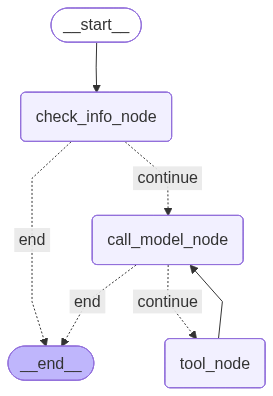

In [195]:
# Visualize the graph
from langchain_core.runnables.graph_mermaid import draw_mermaid_png
from IPython.display import Image

Image(finqa_graph.get_graph().draw_mermaid_png())

## Test the Graph Workflow

Question:
By what percentage did Net Profit After Tax (NPAT) increase from FY23 to FY24?

Answer: NPAT increased by 11.76% from FY23 to FY24.

Question:
By how many million dollars did net investment returns rise in FY24, and what is the percentage increase?

Answer: Investment returns rose by A$210m, a 46.56% increase.

Question:
What proportion of cash earnings did net incurred claims represent in FY24?

Answer: Net incurred claims were 361.1% of cash earnings.

Question:
If Suncorp paid out 72.1% of its cash earnings as dividends in FY24, what was the total dividend amount?

Answer: Total dividends ≈ A$988.3 million.

In [138]:
# Load the  Suncorp df_docs

from parsing_helpers import  parse_embedding

df_docs = pd.read_csv('../data/df_docs.csv')

# Parse the 'summary_emb' column from JSON strings to numpy arrays
df_docs["content_embed"] = df_docs["content_embed"].apply(parse_embedding)

In [199]:

initial_state = FinState(  
    messages=[],
    report_state=True,
    user_query=[],
    next_node=None,
    call_mode='user',
    context_content="",
    context_examples="",
    message_out=None
)





In [200]:
user_id = 'reza'
query="By what percentage did Net Profit After Tax (NPAT) increase from FY23 to FY24?"
state=initial_state
state['messages'] = add_messages(initial_state['messages'], HumanMessage(content=query))
state['user_query'].append(query)

run_config = {'configurable': {'thread_id':user_id}}

response = finqa_graph.invoke(state, config= run_config)
print(response['message_out'])

2025-10-13 01:19:30,333 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


[{'name': 'divide', 'args': {'a': 115, 'b': 1082}, 'id': 'fc_75dab880-4fac-4b42-9ef6-abb23d97687e', 'type': 'tool_call'}]
Tool divide invoked with args {'a': 115, 'b': 1082}, got response: 0.10628465804066543 



2025-10-13 01:19:31,871 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


**Thought:**  
1. The context states that Suncorp’s net profit after tax (NPAT) for FY24 was **$1,197 million**.  
2. For FY23 we can calculate NPAT from the figures given:  
   * Profit before income tax FY23 = **$1,541 million**  
   * Income tax expense FY23 = **$459 million**  
   * NPAT FY23 = 1,541 − 459 = **$1,082 million**.  
3. The dollar increase = 1,197 − 1,082 = **$115 million**.  
4. Percentage increase = 115 ÷ 1,082 ≈ **0.1063** → **10.6 %**.  
   (The divide tool was used to confirm this calculation.)

**References:**  
- Net profit after tax FY24: $1,197 million (context).  
- Profit before income tax FY23: $1,541 million (context).  
- Income tax expense FY23: $459 million (context).  

**Final_answer:**  
Net Profit After Tax (NPAT) increased by **about 10.6 %** from FY23 to FY24.


In [201]:
query="By how many million dollars did net investment returns rise in FY24, and what is the percentage increase?"

state['messages'] = add_messages(initial_state['messages'], HumanMessage(content=query))
state['user_query'].append(query)

run_config = {'configurable': {'thread_id':user_id}}

response = finqa_graph.invoke(state, config= run_config)
print(response['message_out'])

2025-10-13 01:20:01,873 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


[{'name': 'subtract', 'args': {'a': 661, 'b': 451}, 'id': 'fc_7c520ab1-1afc-4248-ba10-bd98216d7112', 'type': 'tool_call'}]
Tool subtract invoked with args {'a': 661, 'b': 451}, got response: 210.0 



2025-10-13 01:20:02,691 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


[{'name': 'divide', 'args': {'a': 210, 'b': 451}, 'id': 'fc_5c30505a-304c-4c66-98ec-668df02db0b3', 'type': 'tool_call'}]
Tool divide invoked with args {'a': 210, 'b': 451}, got response: 0.4656319290465632 



2025-10-13 01:20:03,817 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


**Thought:**  
The context states that net investment returns rose from **$451 million** to **$661 million** in FY24.  
1. **Dollar increase**: \(661 - 451 = 210\) million dollars (calculated with the `subtract` tool).  
2. **Percentage increase**: \(\frac{210}{451} \approx 0.4656\). Multiply by 100 to express as a percent: \(0.4656 \times 100 \approx 46.6\%\) (calculated with the `divide` tool).  

**References:**  
- “Net investment returns were again a key contributor to the topline earnings and profit, up significantly from $451 million to $661 million.” (Context)

**Final_answer:**  
Net investment returns rose by **$210 million** in FY24, which represents a **~46.6 %** increase.


In [203]:
query =" If Suncorp paid out 72.1% of its cash earnings as dividends in FY24, what was the total dividend amount?"

state['messages'] = add_messages(initial_state['messages'], HumanMessage(content=query))
state['user_query'].append(query)

run_config = {'configurable': {'thread_id':user_id}}

response = finqa_graph.invoke(state, config= run_config)
print(response['message_out'])

2025-10-13 01:22:15,199 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


[{'name': 'multiply', 'args': {'a': 1372, 'b': 0.721}, 'id': 'fc_b8bb0ead-33e2-4b46-9290-04fd68a6c664', 'type': 'tool_call'}]
Tool multiply invoked with args {'a': 1372, 'b': 0.721}, got response: 989.212 



2025-10-13 01:22:15,929 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


**Thought:**  
- Cash earnings for FY24 are $1,372 million (from the context).  
- Dividends paid were 72.1 % of cash earnings.  
- Calculate 0.721 × 1,372 million = 989.212 million.  

**References:**  
- “cash earnings increased 16.6% to $1,372 million.”  
- “The Group's full year dividend payout ratio of 72.1% of cash earnings…”  

**Final_answer:**  
Suncorp paid out approximately **$989.2 million** in dividends in FY24.


## Write the agentic workflow

In [16]:
# Load the  Suncorp df_docs
import sys, os
import pandas as pd

sys.path.append('../src')

from parsing_helpers import  parse_embedding

df_docs = pd.read_csv('../data/df_docs.csv')

# Parse the 'summary_emb' column from JSON strings to numpy arrays
df_docs["content_embed"] = df_docs["content_embed"].apply(parse_embedding)

In [27]:
# %%writefile ../src/agentic_system.py

import asyncio
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv
# from langchain_mistralai import MistralAIEmbeddings
import pandas as pd
import json
import numpy as np
import sys
from dotenv import load_dotenv
from langchain.embeddings import HuggingFaceEmbeddings
from typing import  (List, Annotated,Sequence,TypedDict,Any,Optional,Dict,Union,Literal)
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage,SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import interrupt, Command
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver

from parsing_helpers import find_relevant_document_fast, parse_embedding
from tool_helpers import tools, tools_by_name, tool_names
from prompt_helpers import system_message, user_message_new, user_message_tool


load_dotenv()
# Load the FinQA dataset

df_finqa_0 = pd.read_csv('../data/convfinqa_full.csv')

# Parse the 'summary_emb' column from JSON strings to numpy arrays
df_finqa_0["summary_emb"] = df_finqa_0["summary_emb"].apply(parse_embedding)

df_finqa = df_finqa_0[df_finqa_0['has_type2_question'] == True].reset_index(drop=True)


model_id = "openai/gpt-oss-20b" # 	qwen/qwen3-32b  openai/gpt-oss-20b llama-3.1-8b-instant
groq_api_key = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model=model_id,
            temperature=0,
            max_tokens=None,
            timeout=None,
            max_retries=2,
            verbose=1)

# Create embedding model
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")



class FinState(MessagesState):
    """ The state of the AI Assistant"""
    report_state: Annotated[bool, "Whether the financial report is provided by the user"]
    user_query: Annotated[List[str], "The list of questions from the user in continuous chat"]
    next_node: Annotated[Optional[str], "The next node to execute, either 'tool_node' or 'call_model_node'"]
    call_mode: Annotated[Literal['user','tool_call'], "The current mode of the call, either 'user' for model calls or 'tool_call' for tool executions"]
    context_content: Annotated[str, "The relevant content from the financial report to assist in answering the user's query"]
    context_examples: Annotated[Optional[str], "The relevant example conversations from the FinQA dataset to assist in answering the user's query"]
    message_out: Annotated[Optional[str], "The final answer to the user's query, if available"]
    full_response: Annotated[Optional[Any], "The full response from the model, including any tool calls or reasoning steps"]
    query_cont: Annotated[List[str], "Whether this is a new query or a continuation of the previous ones"]

def check_info_node(state: FinState):
    """Check if the financial report is provided by the user"""
    # Simple heuristic: if context_docs is empty or too short, we consider it insufficient
    if not state['report_state']:

        state['next_node'] = "END"
        state['message_out'] = "I'm sorry, but I don't have enough information to answer your question. Please provide the necessary financial documents."
    else:
        state['next_node'] = "call_model_node"
    
    # chekc if this is a new query or continuation
    prompt_template = PromptTemplate.from_template("This is the new query by the user: {new_query}. This is the previous queries by the user: {prev_queries}. Is the new query a continuation of the previous queries or a new one? Only Answer Yes or No.")

    new_query = state['user_query'][-1]
    prev_queries = '\n'.join(state['user_query'][:-1])

    chain = prompt_template|llm
    response = chain.invoke({"new_query": new_query,
                                "prev_queries": '\n'.join(prev_queries)})
    
    print('A continuation Question? ', response.content)
    if 'yes' in response.content.lower():
        state['query_cont'].append(new_query)
    else:
        state['query_cont'] = [new_query]

    print('connected queries: \n ', state['query_cont'])
    return {**state,
            'message_out': state['message_out'],
            'next_node': state['next_node'],
            'query_cont': state['query_cont'],
            "messages": []}

def should_continue_chat(state: FinState):
    """Determine whether to continue the chat or end the cycle."""
    # If there is no function call, then we finish
    if state['next_node']=="END":
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


def tool_node(state: FinState):
    """Execute all tool calls from the last message in the state."""
    outputs = []
    for tool_call in state["full_response"].tool_calls:
        tool_name = tool_call['name']
        tool = tools_by_name[tool_name]
        tool_call_id = tool_call['id']
        tool_args = tool_call['args']
        tool_response = tool.invoke(tool_args)
        tool_message= f"Tool {tool_name} invoked with args {tool_args}, got response: {tool_response} \n"
        print(tool_message)
        outputs.append(
            ToolMessage(
                content=tool_message,
                name=tool_name,
                tool_call_id=tool_call_id,
            )
        )
    return {"messages": outputs}


def call_model_node(state: FinState):
    """Invoke the model with the current conversation state."""
    if state['call_mode']=='user':
        query = state['user_query'][-1]
        queries = '\n'.join(state['query_cont'])
        relevant_docs = find_relevant_document_fast(embedding_model, queries, df_docs, 'content_embed', top_k=4)
        relevant_finq_docs = find_relevant_document_fast(embedding_model, queries, df_finqa, 'summary_emb', top_k=2)

        context_content = '\n'.join([doc for doc in relevant_docs['content']])
        context_examples = '\n'.join([f"Example {i}: {doc}" for i,doc in enumerate(relevant_finq_docs['conv_text_full'])]) 
        state['context_content'] = context_content
        state['context_examples'] = context_examples

        user_message = user_message_new
    else:
        user_message = user_message_tool
        query = state['user_query'][-1]
        context_content = state['context_content']
        context_examples = state['context_examples']

    chat_prompt = ChatPromptTemplate.from_messages([
        system_message,
        user_message
    ])

    model_react=chat_prompt|llm.bind_tools(tools)

    response = model_react.invoke({
        "context_content": context_content
        , "context_examples": context_examples
        , "chat_history": state["messages"]
        , "tool_names": ', '.join(tool_names)
        , "query": query
        })

    state['full_response'] = response
    if not response.tool_calls:
        state['call_mode'] = 'user'
        state['message_out'] = response.content
        out_message = [response.content]
    else:
        state['call_mode'] = 'tool_call'
        print(response.tool_calls)
        out_message = []



    return {**state,
            'call_mode': state['call_mode'],
            'context_content': state['context_content'],
            'context_examples': state['context_examples'],
            'message_out': state['message_out'],
            'full_response': state['full_response'],
            "messages": out_message}


def should_continue_react(state: FinState):
    """Determine whether to continue with tool use or end the ReAct loop."""
    call_mode = state['call_mode']
    # If there is no function call, then we finish
    if call_mode=='user':
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


builder = StateGraph(FinState)
builder.add_node("check_info_node", check_info_node)
builder.add_node("call_model_node", call_model_node)
builder.add_node("tool_node", tool_node)

builder.add_edge(START, "check_info_node")
builder.add_conditional_edges("check_info_node",
                              should_continue_chat, 
                              {"continue": "call_model_node",
                               "end": END})
builder.add_conditional_edges("call_model_node", 
                              should_continue_react, 
                              {"continue": "tool_node",
                               "end": END})
builder.add_edge("tool_node", "call_model_node")

finqa_graph = builder.compile(checkpointer=InMemorySaver())



class FinQAResponseAgent:
    """Async wrapper for running the finqa_graph ReAct agent as a reusable service."""

    def __init__(self, agent_graph, report_state: bool = False):
        """
        Initialize the response agent.

        Args:
            agent_graph: Compiled LangGraph instance (e.g., finqa_graph)
            report_state: Whether the financial report is provided by the user
        """
        self.agent = agent_graph
        self.report_state = report_state
        self.df_docs = None  # To be set after PDF upload

    def set_report_state(self, value: bool):
        """Update report_state dynamically (e.g., after PDF upload)."""
        self.report_state = value
    
    def set_documents(self, df_docs):
        """Attach parsed financial report (and optionally embedding model) to the agent."""
        self.df_docs = df_docs

    def convert_input(self, input_data: Dict[str, Any]) -> Dict[str, Any]:
        """
        Convert user input to a format acceptable by finqa_graph.

        Args:
            input_data (dict): {'user_id': ..., 'user_input': ...}

        Returns:
            dict: Input state for the LangGraph.
        """
        user_input = input_data.get("user_input", "")
        user_id = input_data.get("user_id", "default_user")

        # Build run config for this user
        run_config = {"configurable": {"thread_id": user_id}}

        # Check if a state already exists (for continuity)
        existing_state = self.agent.get_state(config=run_config)

        # Build initial state only if needed
        if existing_state is None or not existing_state.values:
            state = {
                "messages": [],
                "report_state": self.report_state,  
                "user_query": [user_input],
                "next_node": None,
                "call_mode": "user",
                "context_content": "",
                "context_examples": "",
                "message_out": None,
                "full_response": None,
            }
            state['messages'] = add_messages(state['messages'], HumanMessage(content=user_input))
        else:
            state = existing_state.values
            state['user_query'].append(user_input)
            state['report_state'] = self.report_state  # Ensure it's updated


        state['messages'] = add_messages(state['messages'], HumanMessage(content=user_input))

        return {"state": state, "run_config": run_config}

    async def predict(self, input_data: Dict[str, Any]) -> str:
        """
        Run the finqa_graph and return the model output.

        Args:
            input_data (dict): {'user_id': ..., 'user_input': ...}

        Returns:
            str: The model's response (message_out)
        """
        if self.df_docs is not None:
            globals()["df_docs"] = self.df_docs
        
        converted = self.convert_input(input_data)
        state = converted["state"]
        run_config = converted["run_config"]

        # Run the graph asynchronously
        agent_response = await self.agent.ainvoke(state, config=run_config)

        # Retrieve the model output
        message_out = agent_response["message_out"]

        return {"output": message_out,
                "full_response": agent_response['full_response']
        }


FinQAAgent = FinQAResponseAgent(finqa_graph)


Overwriting ../src/agentic_system.py


## Test the Agent

### Question:
By what percentage did Net Profit After Tax (NPAT) increase from FY23 to FY24?

- Answer: NPAT increased by 11.76% from FY23 to FY24.

### Question:
By how many million dollars did net investment returns rise in FY24, and what is the percentage increase?

- Answer: Investment returns rose by A$210m, a 46.56% increase.

###  Question:
What proportion of cash earnings did net incurred claims represent in FY24?

- Answer: Net incurred claims were 361.1% of cash earnings.

### Question:
If Suncorp paid out 72.1% of its cash earnings as dividends in FY24, what was the total dividend amount?

- Answer: Total dividends ≈ A$988.3 million.

In [30]:
# Test the async agent with sample

async def test_agent():
    """Test the FinQAResponseAgent with a sample input."""
    FinQAAgent.set_report_state(True)
    FinQAAgent.set_documents(df_docs)
    input_to_agent = {"user_id": "Carly", 
                      "user_input": "If Suncorp paid out 72.1% of its cash earnings as dividends in FY24, what was the total dividend amount?"}
    response = await FinQAAgent.predict(input_to_agent)
    print(r"💬 Agent Response:\n", response['output'])
    print("--------------------------------------------------")
    print(r"💬 Full messages:\n", response['full_response'])



# Run the async workflow
await test_agent()

2025-10-14 00:31:12,051 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


A continuation Question?  No
connected queries: 
  ['If Suncorp paid out 72.1% of its cash earnings as dividends in FY24, what was the total dividend amount?']


2025-10-14 00:31:13,316 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


[{'name': 'multiply', 'args': {'a': 1372, 'b': 0.721}, 'id': 'fc_cfeca33c-59a7-4bb0-a364-6f0cb537fd0b', 'type': 'tool_call'}]
Tool multiply invoked with args {'a': 1372, 'b': 0.721}, got response: 989.212 



2025-10-14 00:31:14,227 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


💬 Agent Response:\n Thought:  
1. The context states that cash earnings for FY24 were $1,372 million.  
2. The dividend payout ratio is 72.1% of those cash earnings.  
3. Multiply 1,372 million by 0.721 to find the total dividend amount.  
4. The tool calculation confirms the result: 1,372 × 0.721 = 989.212 million.

References:  
- “cash earnings increased 16.6% to $1,372 million.”  
- “The Group's full year dividend payout ratio of 72.1% of cash earnings …”

Final_answer: The total dividend paid in FY24 was **$989.212 million**.
--------------------------------------------------
💬 Full messages:\n content="Thought:  \n1. The context states that cash earnings for FY24 were $1,372\u202fmillion.  \n2. The dividend payout ratio is 72.1% of those cash earnings.  \n3. Multiply 1,372\u202fmillion by 0.721 to find the total dividend amount.  \n4. The tool calculation confirms the result: 1,372\u202f×\u202f0.721\u202f=\u202f989.212\u202fmillion.\n\nReferences:  \n- “cash earnings increased 16